# EEG preprocessing with MNE

Imports

In [32]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autoreject import AutoReject
from autoreject import get_rejection_threshold
ar = AutoReject()
import copy

## 1. Import data with pre-defined format (e.g., EDF, BDF, BrainVision)

In [2]:
brainvision_fname ="../ds003944/sub-2143/eeg/sub-2143_task-Rest_eeg.vhdr"

In [3]:
brainvision_raw = mne.io.read_raw_brainvision(brainvision_fname, preload=True)
brainvision_raw

Extracting parameters from ../ds003944/sub-2143/eeg/sub-2143_task-Rest_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...


<RawBrainVision | sub-2143_task-Rest_eeg.eeg, 64 x 300000 (300.0 s), ~146.5 MB, data loaded>

Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


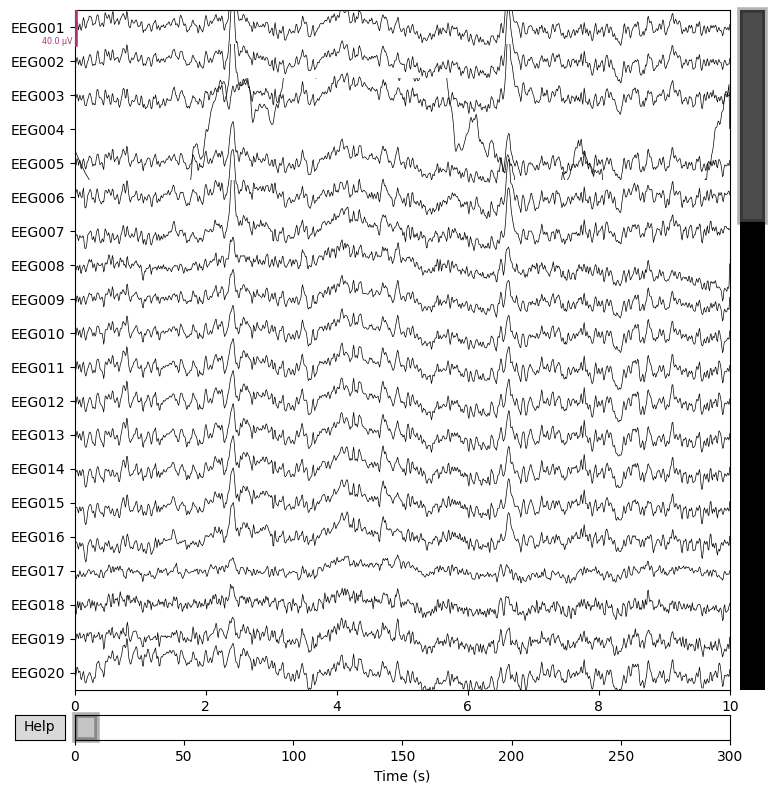

In [4]:
fig = brainvision_raw.plot(highpass=0.1, lowpass=30)

## 2. Ensure right format of data

### 2.1 Rename channels (if they have wrong names)

In [5]:
brainvision_raw.info["ch_names"]

['EEG001',
 'EEG002',
 'EEG003',
 'EEG004',
 'EEG005',
 'EEG006',
 'EEG007',
 'EEG008',
 'EEG009',
 'EEG010',
 'EEG011',
 'EEG012',
 'EEG013',
 'EEG014',
 'EEG015',
 'EEG016',
 'EEG017',
 'EEG018',
 'EEG019',
 'EEG020',
 'EEG021',
 'EEG022',
 'EEG023',
 'EEG024',
 'EEG025',
 'EEG026',
 'EEG027',
 'EEG028',
 'EEG029',
 'EEG030',
 'EEG031',
 'EEG032',
 'EEG033',
 'EEG034',
 'EEG035',
 'EEG036',
 'EEG037',
 'EEG038',
 'EEG039',
 'EEG040',
 'EEG041',
 'EEG042',
 'EEG043',
 'EEG044',
 'EEG045',
 'EEG046',
 'EEG047',
 'EEG048',
 'EEG049',
 'EEG050',
 'EEG051',
 'EEG052',
 'EEG053',
 'EEG054',
 'EEG055',
 'EEG056',
 'EEG057',
 'EEG058',
 'EEG059',
 'EEG060',
 'EEG061',
 'EEG062',
 'EEG063',
 'EEG064']

In [6]:
channels_new_names_dict = {
    'EEG019':'FC5',
    'EEG020':'FC1',
    'EEG021':'FC2',
    'EEG022':'FC6',
    'EEG027':'C5',
    'EEG028':'C3',
    'EEG029':'C1',
    'EEG030':'Cz',
    'EEG031':'C2',
    'EEG032':'C4',
    'EEG033':'C6',
    'EEG038':'CP3',
    'EEG039':'CP1',
    'EEG040': 'CP2',
    'EEG041': 'CP4',
    'EEG001': 'Fp1',
    'EEG002': 'Fpz',
    'EEG003': 'Fp2',
    'EEG004': 'AF7',
    'EEG005': 'AF3',
    'EEG006': 'AF4',
    'EEG008': 'F7',
    'EEG009': 'F5',
    'EEG010': 'F3',
    'EEG011': 'F1',
    'EEG012': 'Fz',
    'EEG013': 'F2',
    'EEG014': 'F4',
    'EEG015': 'F6',
    'EEG016': 'F8',
    'EEG018': 'FT7',
    'EEG023': 'FT8',
    'EEG034': 'T8',
    'EEG035': 'T10',
    'EEG045': 'P5',
    'EEG046': 'P3',
    'EEG047': 'P1',
    'EEG048': 'Pz',
    'EEG049': 'P2',
    'EEG050': 'P4',
    'EEG051': 'P6',
    'EEG052': 'P8',
    'EEG053': 'PO7',
    'EEG054': 'PO3',
    'EEG055': 'PO4',
    'EEG056': 'PO8',
    'EEG057': 'O1',
    'EEG058': 'Oz',
    'EEG059': 'O2',
    'EEG060': 'Iz',
    "EEG007": 'AF6',
    "EEG017": 'FT9',
    "EEG024": 'FT10',
    "EEG025": 'T9',
    "EEG026": 'T7',
    "EEG042": 'TP8',
    "EEG043": 'TP10',
    "EEG044": 'P7',
    "EEG061": 'VEOG',
    "EEG062": 'Misc',
    "EEG063": 'ECG',
    "EEG064": 'M2',
    "EEG036": 'TP9',
    "EEG037": 'TP7'


    
}

In [7]:
brainvision_raw.rename_channels(channels_new_names_dict)

<RawBrainVision | sub-2143_task-Rest_eeg.eeg, 64 x 300000 (300.0 s), ~146.5 MB, data loaded>

### 2.2 Set channels types

If your list of channels includes: 
 - VEOG, HEOG: change type of this channel to "eog"'
 - Misc: change type of this channel to "misc";
 - ECG: change type of this channel to "ecg";
 - some strange, unknown channels: change to "misc";
 - remember that M1/M2 are eeg channels - so called reference channels. 

```
raw.set_channel_types({
    'VEOG': 'eog',
    'HEOG': 'eog',
    'ECG': 'ecg'
})
```

In [8]:
brainvision_raw.info["ch_names"]

['Fp1',
 'Fpz',
 'Fp2',
 'AF7',
 'AF3',
 'AF4',
 'AF6',
 'F7',
 'F5',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT9',
 'FT7',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'FT8',
 'FT10',
 'T9',
 'T7',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'T10',
 'TP9',
 'TP7',
 'CP3',
 'CP1',
 'CP2',
 'CP4',
 'TP8',
 'TP10',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO7',
 'PO3',
 'PO4',
 'PO8',
 'O1',
 'Oz',
 'O2',
 'Iz',
 'VEOG',
 'Misc',
 'ECG',
 'M2']

In [9]:
brainvision_raw.set_channel_types({
    'VEOG':'eog',
    'ECG':'ecg',
    'Misc':'misc',
    'M2':'eeg'
})

<RawBrainVision | sub-2143_task-Rest_eeg.eeg, 64 x 300000 (300.0 s), ~146.5 MB, data loaded>

### 2.3 Set montage (of EEG cap)

This method will fail if the electrodes are named incorrectly (!)

In [10]:
brainvision_raw.set_montage('standard_1020')

<RawBrainVision | sub-2143_task-Rest_eeg.eeg, 64 x 300000 (300.0 s), ~146.6 MB, data loaded>

## 3. Filtering data

Filtering must be performed on the raw, continuous signal, as it can induce some artifacts in the edges of the signal.

- notch filter: to filter out line noise. 

If the power line noise has not been removed from the signal, we can observe on the power spectrum density chart which frequencies we should remove - 60 Hz in the US and 50 Hz in Europe.

Effective window size : 0.256 (s)


c:\dev\python\.venv\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


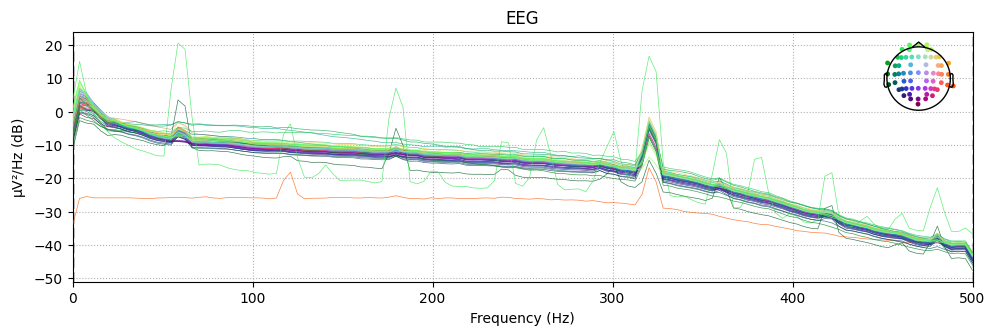

In [11]:
brainvision_raw.compute_psd().plot()

In [12]:
edf_nyquist_freq = brainvision_raw.info["sfreq"] / 2
print(edf_nyquist_freq)

freq_of_interest = 60

brainvision_raw.notch_filter(freqs=np.arange(freq_of_interest, edf_nyquist_freq, freq_of_interest), picks='eeg')

500.0
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    1.1s finished


<RawBrainVision | sub-2143_task-Rest_eeg.eeg, 64 x 300000 (300.0 s), ~146.6 MB, data loaded>

Effective window size : 0.256 (s)


c:\dev\python\.venv\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


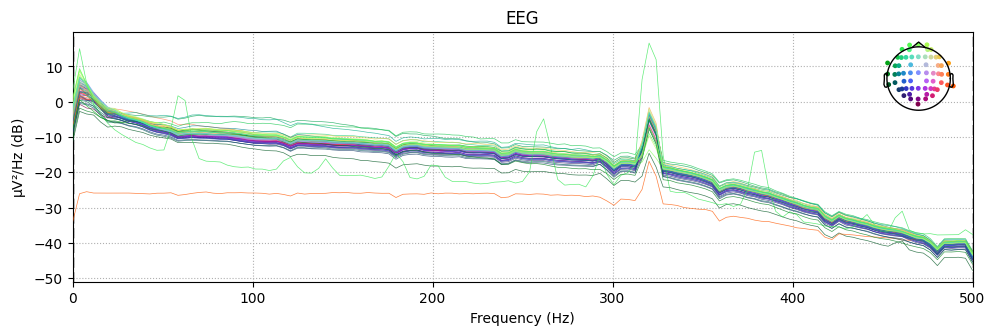

In [13]:
brainvision_raw.compute_psd().plot() # no visible line noise

- band-pass filter: to filter very low frequencies (slow drifts) and high frequencies (e.g. from muscles)

Here the lower limit is set to 0.05 Hz; the upper limit is set to 30 Hz. Note that if you are interested in higher frequencies than 30 Hz, you need to increase the upper limit of the bandpass filter. The highest frequency that can be analyzed is the so-called Nyquist frequency, which is half the sampling frequency.

In [14]:
brainvision_raw.filter(0.05, 30, method="iir", picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.05, 30.00 Hz: -6.02, -6.02 dB



<RawBrainVision | sub-2143_task-Rest_eeg.eeg, 64 x 300000 (300.0 s), ~146.6 MB, data loaded>

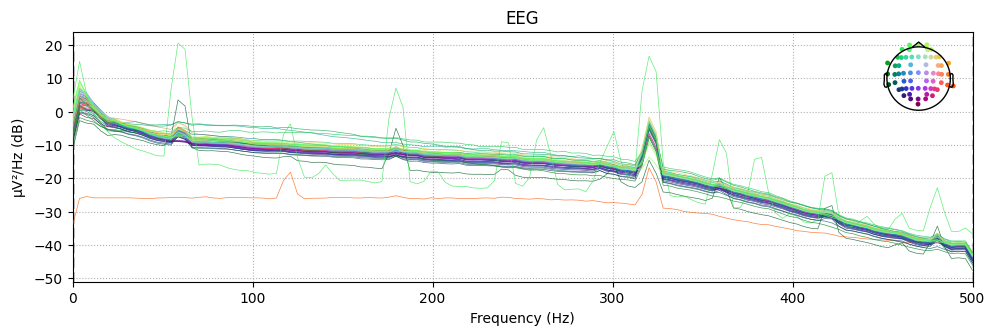

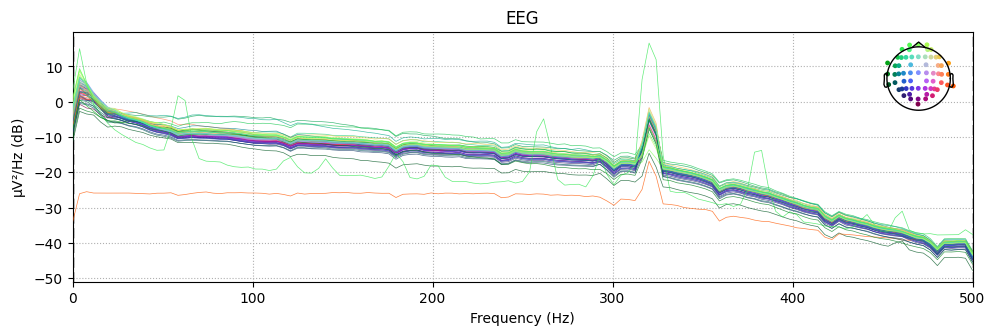

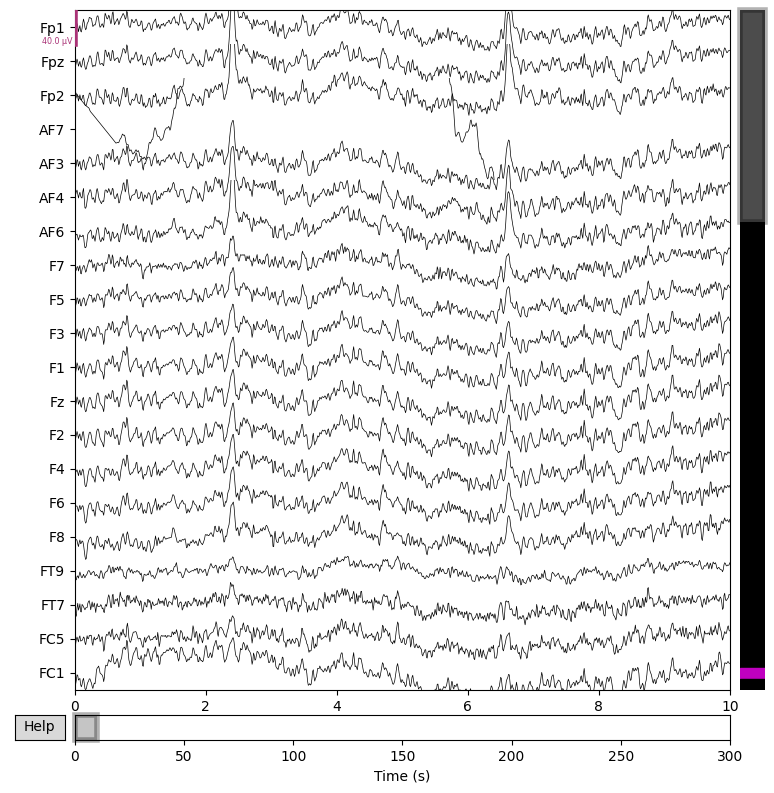

In [15]:
fig = brainvision_raw.plot()

## 4. Reference

If you have 'M1' or 'M2' or both channels in your data - you sholud re-reference your signal to those channels:

```
raw.set_eeg_reference(ref_channels=['M1', 'M2'])
```

If not, you can (but it's not necessary) reference your signal to average of all channels:

```
raw.set_eeg_reference(ref_channels='average')
```


In [16]:
reference = 'average'
brainvision_raw.set_eeg_reference(ref_channels=reference)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | sub-2143_task-Rest_eeg.eeg, 64 x 300000 (300.0 s), ~146.6 MB, data loaded>

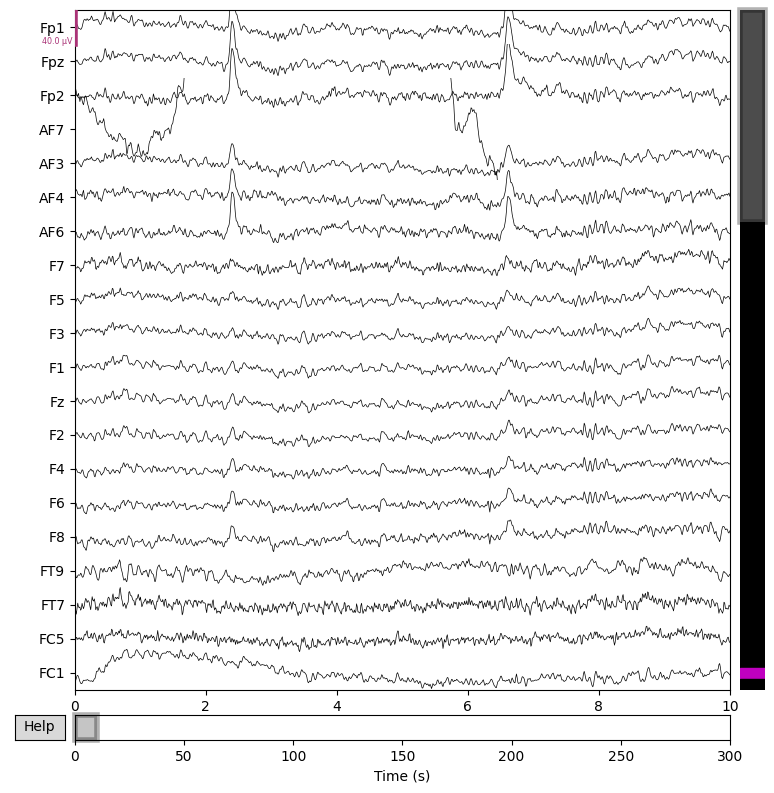

In [17]:
fig = brainvision_raw.plot()

In [18]:
reference = ['M2']
brainvision_raw.set_eeg_reference(ref_channels=reference)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawBrainVision | sub-2143_task-Rest_eeg.eeg, 64 x 300000 (300.0 s), ~146.6 MB, data loaded>

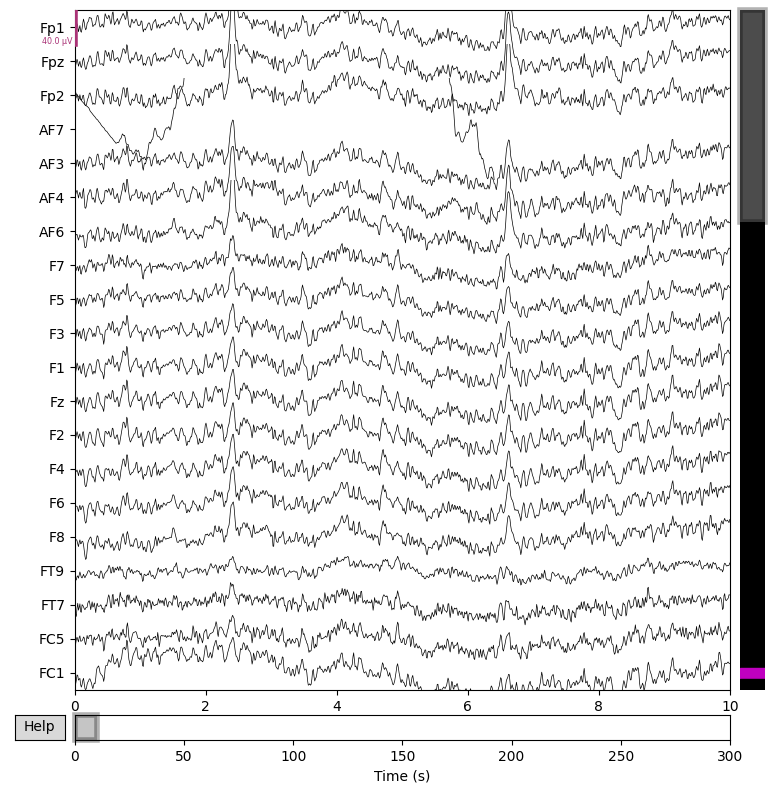

In [19]:
fig = brainvision_raw.plot()

## 5. Data segmentation into epochs

EEG signal must be segmented to further get rid of ocular (and other) artifacts. Signal should be segmented with user-selected time window around events occurring in the signal, e.g., -.1 to .6 (-100 ms to 600 ms around event). There should always be a larger chunk of the signal cut than just a small region of interest.

To segment data, you have to provide the events of interest and the event dict. There are few options:
- if you already have events in your signal (from annotations), you can extrat those event with `mne.events_from_annotations(raw)`;
- if you created your Raw from scratch, you have to create MNE-like events and event_dict;
- if you do not have events (in case of resting state signal without events) you can use `mne.make_fixed_length_epochs(raw, duration=30, preload=True)`;

In [20]:
# extract all events encoded in EEG signal
events_from_annotations, events_dict_from_annotations = mne.events_from_annotations(brainvision_raw)
print(events_dict_from_annotations)

{}


In [21]:
mat_epochs = mne.make_fixed_length_epochs(brainvision_raw, duration=30, preload=True)

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 30000 original time points ...
0 bad epochs dropped


## 6. Ocular correction with ICA

Here, we use Independent Component Analysis to remove the signal coming from the eyes from the brain signal. For more info, see [MNE tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html).

- if you have EOG channels - use `find_bads_eog()` with defaults - it will serach for EOG channels;
- if you don't have EOG channel, use very frontal channel e.g. Fpz - it will use Fpz as proxy for EOG;

Create ICA object and fit it to data

In [22]:
ica = mne.preprocessing.ICA(n_components=50, random_state=42, method="infomax")
ica.fit(mat_epochs)

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 50 components
 
Fitting ICA took 520.9s.


<ICA | epochs decomposition, method: infomax (fit in 500 iterations on 300000 samples), 50 ICA components (61 PCA components available), channel types: eeg, no sources marked for exclusion>

Search for EOG signal

In [23]:
ica.exclude=[]
eog_indices, eog_sources = ica.find_bads_eog(
    mat_epochs, 
    measure='zscore', 
    threshold='auto'
)

ica.exclude = eog_indices
print(ica.exclude)

Using EOG channel: VEOG
[3]


Reconstruct EEG signal without EOG artifacts

In [24]:
ica.apply(mat_epochs)

Applying ICA to Epochs instance
    Transforming to ICA space (50 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


<Epochs |  10 events (all good), 0 - 29.999 sec, baseline off, ~146.6 MB, data loaded,
 '1': 10>

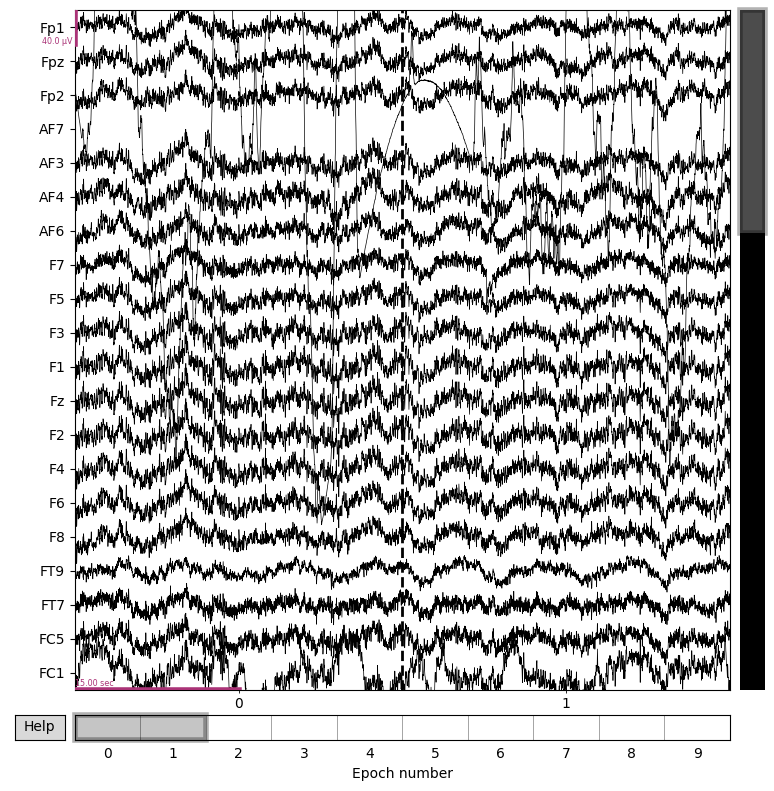

In [25]:
fig = mat_epochs.plot(n_epochs=2)

## 7. Interploate bad channels

In this case we do this after coluar correction, as in EDF example Fpz was our 'blink channel'. Usually you should do this after re-referencing, on raw data:

```
raw.info['bads'] = ['Fp1', 'Fp2', 'AF7', 'AF8']
raw = raw.interpolate_bads(reset_bads=False)
```

Fp - AF channels are often very noisy due to eye movement - it's worth to interpolate them

In [26]:
mat_epochs.info['bads'] = ['Fp1', 'Fp2', 'AF3', 'AF4']

mat_epochs = mat_epochs.interpolate_bads(reset_bads=False)

Interpolating bad channels
    Automatic origin fit: head of radius 97.1 mm
Computing interpolation matrix from 57 sensor positions
Interpolating 4 sensors


## 8. Artifact rejection

MNE `drop_bad()` reject epochs based on maximum peak-to-peak signal amplitude (PTP), i.e. the absolute difference between the lowest and the highest signal value. In each individual epoch, the PTP is calculated for every channel. If the PTP of any one channel exceeds the rejection threshold, the respective epoch will be dropped.

There is no good artifact rejection criterium, especially when you do not know your dataset. Even now I'm not sure of magnitude of EEG signal (whether it's in V). Also the paradigm might influence your signal and make it noisy. So - I recommend test rejection criteria for one person and THEN apply it in a loop to all participants.

Usually `reject_criteria = dict(eeg=100e-6)` is fine and often used, but - as you can see below - sometimes the signal is so strange that with such a rejection criterion we lose all segments. It is worth checking whether this situation occurs in all participants, or whether there is one that "misbehaved" ;)

In [27]:
original_data = mat_epochs.copy() # store original data in a new variable

In [ ]:
#original rejection method

reject_criteria = dict(eeg=500e-6)

mat_epochs.drop_bad(reject=reject_criteria)

In [ ]:
#autoreject method

# Fit and apply autoreject to data
mat_epochs_clean, reject_log = ar.fit_transform(mat_epochs, return_log=True)

# Get the rejection threshold
threshes = get_rejection_threshold(mat_epochs)

# Compute the percentage of epochs removed by channel
epochs_removed_pct = 100 * reject_log.bad_epochs.sum(axis=0) / mat_epochs_clean.get_data().shape[0]

# Plot the percentage of epochs removed by channel
fig, ax = plt.subplots()
ax.bar(range(len(epochs_removed_pct)), epochs_removed_pct)
ax.axhline(threshes['eeg'], color='r', linestyle='--', label='Rejection Threshold')
ax.set_xlabel('Channel')
ax.set_ylabel('% of epochs removed')
ax.legend()
plt.show()

In [64]:
mat_epochs = original_data.copy() #recreate the instance using the original data, use if you want to try different rejection methods

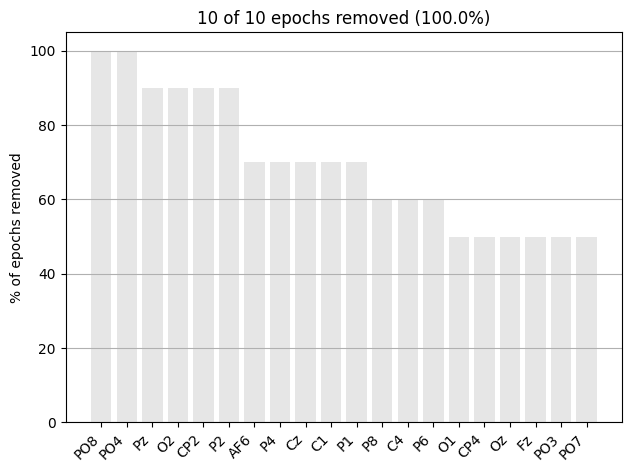

In [32]:
fig = mat_epochs.plot_drop_log()

---

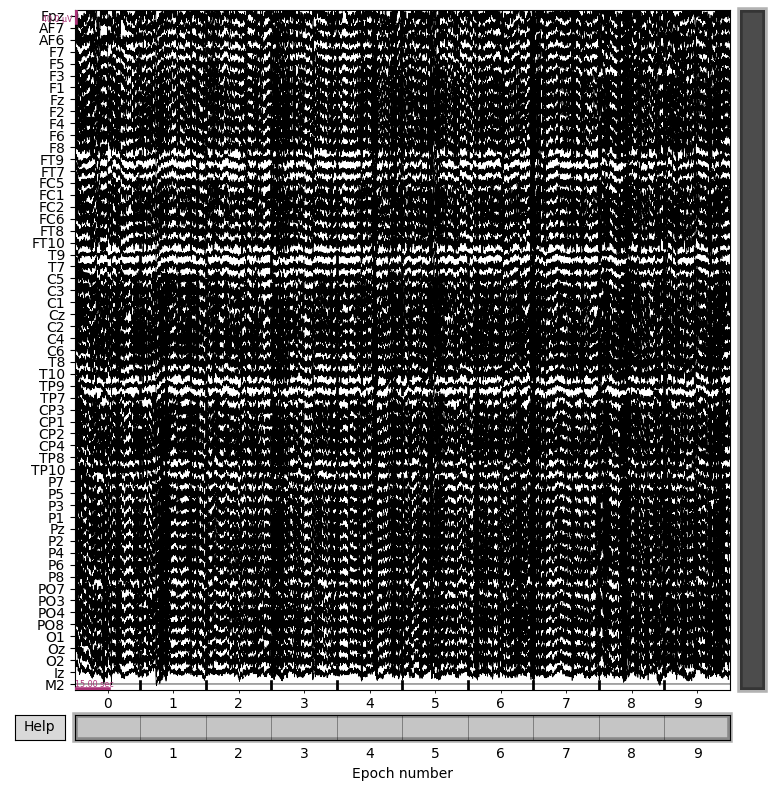

In [66]:
fig = mat_epochs.plot(n_epochs=10, n_channels=64)

### Now your data are ready for feature extraction :)

To avoid performing pre-processing for each run, you can save your pre-processes data:

In [317]:
dir_with_data = "" # path to your data dir, eg. "data/" Remember the slash after the dir name !
sub_id = edf_fname[:-4]
edf_epochs.save(f"{dir_with_data}{sub_id}-epo.fif")

And you can read saved data:

In [318]:
fname = sub_id + "-epo.fif"
edf_epochs_readed = mne.read_epochs(fname)
edf_epochs_readed

Reading /home/anna/Work/erpinator/notebooks/zosia_bci_test/S001R03-epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF |  9 events (all good), -2 - 2 sec, baseline -0.2 – 0 sec, ~2.9 MB, data loaded,
 'T1': 6
 'T2': 3>

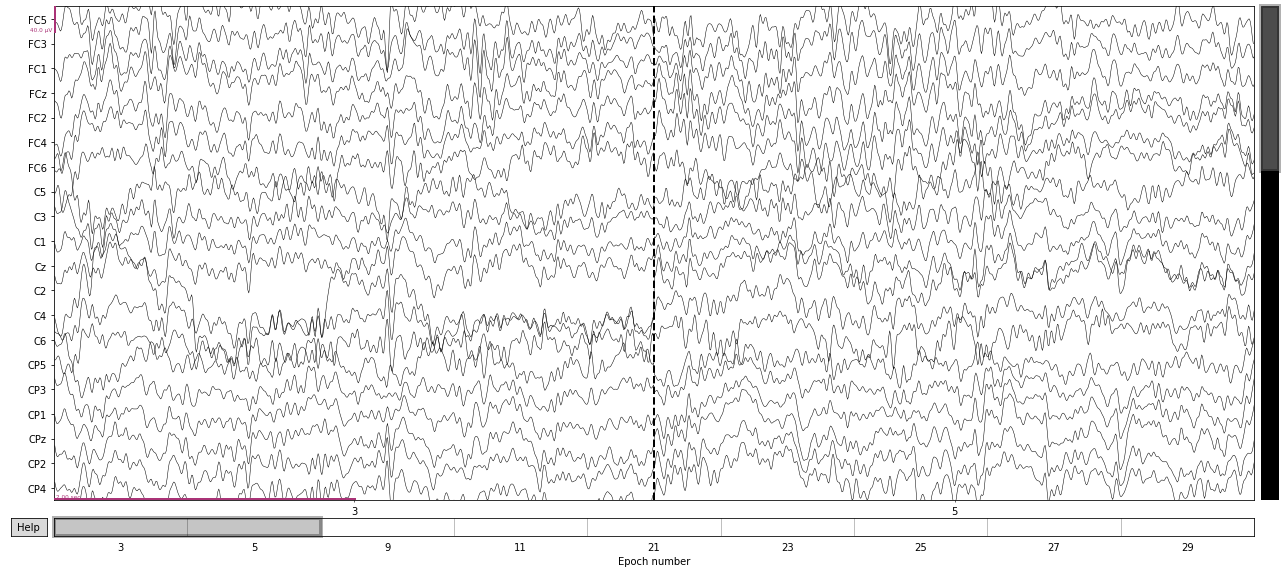

In [319]:
fig = edf_epochs_readed.plot(n_epochs=2)

In [71]:
dir_with_data = "preprocessed-data/" # path to your data dir, eg. "data/" Remember the slash after the dir name !
sub_id = brainvision_fname[:-4]
mat_epochs.save(f"{dir_with_data}{sub_id}-epo.fif")

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\dev\\python\\eggML-project\\preprocessed-data\\..\\ds003944\\sub-1824\\eeg\\sub-1824_task-Rest_eeg.-epo.fif'

In [69]:
fname = sub_id + "-epo.fif"
mat_epochs_readed = mne.read_epochs(fname)
mat_epochs_readed

Reading c:\dev\python\eggML-project\..\ds003944\sub-1824\eeg\sub-1824_task-Rest_eeg.-epo.fif ...
    Found the data of interest:
        t =       0.00 ...   29999.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF |  10 events (all good), 0 - 29.999 sec, baseline off, ~146.6 MB, data loaded,
 '1': 10>

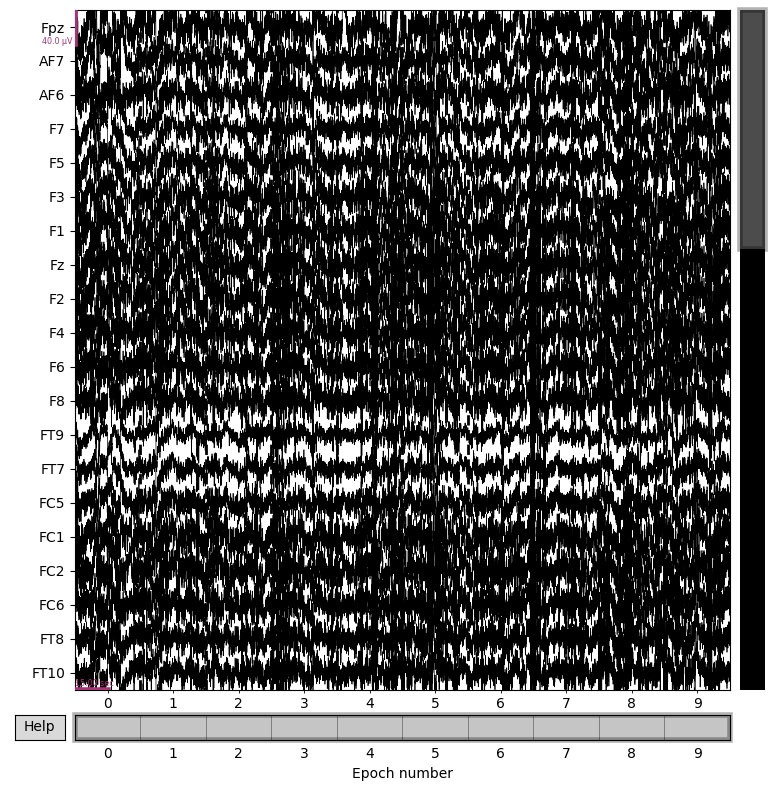

In [70]:
fig = mat_epochs_readed.plot(n_epochs=10)